# Which COVID-19 Vaccine is Best for You?
## DS4A Team 55 Preliminary EDA


In [49]:
import pandas as pd
import numpy as np
import math
import base64
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
import zipfile

In [18]:
# increase the size and quality of any plots we produce
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300

### state_vax.csv
Vaccine administration data for states within the U.S., including the District of Columbia from 12/13/2020 to the present, updated daily. 

In [2]:
client = Socrata(
        domain = "data.cdc.gov",
        app_token = "bsYMLkKAQhIIVd7wzBzp5BiCR",
        timeout=10
        )
results = client.get_all("unsk-b7fc")

# convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df.sample(10)

,date,mmwr_week,location,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_unk_manuf,dist_per_100k,distributed_per_100k_12plus,...,administered_dose1_recip_5pluspop_pct,series_complete_5plus,series_complete_5pluspop_pct,administered_5plus,admin_per_100k_5plus,distributed_per_100k_5plus,series_complete_moderna_5plus,series_complete_pfizer_5plus,series_complete_janssen_5plus,series_complete_unk_manuf_5plus
2561,2021-11-28T00:00:00.000,48,LA,6711910,292600,2765480,3653830,0,144380,171077,...,59.1,2262102,52,5161897,118737,154392,907446,1190254,163413,989
5288,2021-10-17T00:00:00.000,42,AR,4224440,199600,1827580,2197260,0,139984,165195,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
15291,2021-05-16T00:00:00.000,20,AS,54030,600,15600,37830,0,97021,113611,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
17094,2021-04-18T00:00:00.000,16,FM,63200,1600,61600,0,0,60979,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3789,2021-11-09T00:00:00.000,45,PR,5265440,204100,2187040,2874300,0,164870,184863,...,85.9,2360457,76.7,5116637,166329,171166,902276,1323049,135051,81
1088,2021-12-21T00:00:00.000,51,SC,8745535,435200,3459600,4850735,0,169859,197864,...,65.8,2715199,55.9,6578474,135464,180088,994092,1525191,195574,342
7995,2021-09-05T00:00:00.000,36,CT,5385255,250000,2189300,2945955,0,151047,173385,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
10604,2021-07-27T00:00:00.000,30,CT,4894665,250000,1996160,2648505,0,137287,157590,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
23487,2021-01-10T00:00:00.000,2,SC,255450,0,0,0,0,4961,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
14341,2021-05-31T00:00:00.000,22,VA,9792225,533200,3848360,5410665,0,114723,134012,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [3]:
# df.info()

In [4]:
# remove all distribution cols
# remove "Administered", this is the total for 1st dose and complete series
# remove all 5plus cols, very recently approved and sporadic across states
# remove additional doses for 50plus, age group doesn't show up elsewhere in dataset


df = df.drop(columns= ["mmwr_week","distributed", "distributed_janssen", "distributed_moderna", 
                       "distributed_pfizer", "distributed_unk_manuf", "dist_per_100k","distributed_per_100k_12plus",
                       "distributed_per_100k_18plus", "distributed_per_100k_65plus", "distributed_per_100k_5plus",
                       "administered","administered_dose1_recip_5plus",
                       "administered_dose1_recip_5pluspop_pct", "series_complete_5plus", "series_complete_5pluspop_pct", 
                       "administered_5plus", "admin_per_100k_5plus", "series_complete_moderna_5plus",
                       "series_complete_pfizer_5plus", "series_complete_janssen_5plus", "series_complete_unk_manuf_5plus",
                       "additional_doses_50plus", "additional_doses_50plus_vax_pct"], axis=1)

In [5]:
# abbreviating column names for readability
# cols in api data are labelled differently than csv directly from data.cdc.gov, values match up so renaming those cols

rename_cols = {"administered_12plus":"admin_12plus", 
               "administered_18plus":"admin_18plus",
               "administered_65plus":"admin_65plus",
               "administered_janssen":"admin_janssen",
               "administered_moderna":"admin_moderna",
               "administered_pfizer":"admin_pfizer",
               "administered_unk_manuf":"admin_unk",
               "recip_administered":"recip_admin",
               "administered_dose1_recip":"admin_dose1",
               "administered_dose1_pop_pct":"admin_dose1_pop_pct",
               "administered_dose1_recip_1":"admin_dose1_12plus",
               "administered_dose1_recip_2":"admin_dose1_12plus_pop_pct",
               "administered_dose1_recip_3":"admin_dose1_18plus",
               "administered_dose1_recip_4":"admin_dose1_18plus_pop_pct",
               "administered_dose1_recip_5":"admin_dose1_65plus",
               "administered_dose1_recip_6":"admin_dose1_65plus_pop_pct",
               "series_complete_yes":"series_complete",
               "series_complete_12pluspop":"series_complete_12plus_pop_pct",
               "series_complete_18pluspop":"series_complete_18plus_pop_pct",
               "series_complete_65pluspop":"series_complete_65plus_pop_pct",
               "series_complete_unk_manuf":"series_complete_unk",
               "series_complete_unk_manuf_1":"series_complete_unk_12plus",
               "series_complete_unk_manuf_2":"series_complete_unk_18plus",
               "series_complete_unk_manuf_3":"series_complete_unk_65plus",
               "series_complete_12pluspop_pct":"series_complete_12plus_pop_pct",
               "series_complete_18pluspop_pct":"series_complete_18plus_pop_pct",
               "series_complete_65pluspop_pct":"series_complete_65plus_pop_pct"
               }
df = df.rename(columns=rename_cols)

In [6]:
# df.columns

In [7]:
# see data types of df
# all types = object, need to change to ints and floats
# df.dtypes

In [8]:
# show cols with NaNs
# cols with NaNs are additional dose cols, after investigating this happens when other additional dose cols are 0
df.columns[df.isnull().any()]

Index(['additional_doses', 'additional_doses_vax_pct',
       'additional_doses_18plus', 'additional_doses_18plus_vax_pct',
       'additional_doses_65plus', 'additional_doses_65plus_vax_pct',
       'additional_doses_moderna', 'additional_doses_pfizer',
       'additional_doses_janssen', 'additional_doses_unk_manuf'],
      dtype='object')

In [9]:
# replace NaNs with 0 to fill in values
nan_col = ['additional_doses', 'additional_doses_vax_pct',
           'additional_doses_18plus', 'additional_doses_18plus_vax_pct',
           'additional_doses_65plus', 'additional_doses_65plus_vax_pct',
           'additional_doses_moderna', 'additional_doses_pfizer',
           'additional_doses_janssen', 'additional_doses_unk_manuf']
df[nan_col] = df[nan_col].fillna(0)

In [10]:
to_int = ['admin_12plus', 'admin_18plus', 'admin_65plus','admin_janssen',
          'admin_moderna', 'admin_pfizer', 'admin_unk','admin_per_100k',
          'admin_per_100k_12plus', 'admin_per_100k_18plus','admin_per_100k_65plus',
          'recip_admin', 'admin_dose1', 'admin_dose1_12plus', 'admin_dose1_18plus',
          'admin_dose1_65plus', 'series_complete_12plus', 'series_complete_18plus',
          'series_complete','series_complete_65plus', 'series_complete_janssen', 'series_complete_moderna',
          'series_complete_pfizer','series_complete_unk', 'series_complete_janssen_12plus',
          'series_complete_moderna_12plus', 'series_complete_pfizer_12plus', 'series_complete_unk_12plus',
          'series_complete_janssen_18plus', 'series_complete_moderna_18plus', 'series_complete_pfizer_18plus',
          'series_complete_unk_18plus', 'series_complete_janssen_65plus', 'series_complete_moderna_65plus',
          'series_complete_pfizer_65plus', 'series_complete_unk_65plus', 'additional_doses',
          'additional_doses_18plus', 'additional_doses_65plus', 'additional_doses_moderna',
          'additional_doses_pfizer', 'additional_doses_janssen', 'additional_doses_unk_manuf'
         ]

to_float = ['admin_dose1_pop_pct', 'admin_dose1_12plus_pop_pct', 'admin_dose1_18plus_pop_pct',
            'admin_dose1_65plus_pop_pct', 'series_complete_pop_pct', 'series_complete_12plus_pop_pct',
            'series_complete_12plus_pop_pct', 'series_complete_18plus_pop_pct', 'series_complete_65plus_pop_pct',
            'additional_doses_vax_pct', 'additional_doses_18plus_vax_pct', 'additional_doses_65plus_vax_pct'
           ]

df[to_int] = df[to_int].astype("int")
df[to_float] = df[to_float].astype("float")

In [11]:
# checking that data types hace been converted correctly
# df.dtypes

In [12]:
# removing locations outside of the contential united states as well as united states total

drop_location = ["AS", "BP2", "DD2", "FM", "GU",
                 "IH2", "MH", "MP", "PR", "RP",
                 "US", "VA2", "VI", "LTC"]
df = df[~df["location"].isin(drop_location)]

# checking that location vals = 51, including DC

df.location.nunique()

51

In [13]:
# converting "date" col to datetime
df["date"] = pd.to_datetime(df["date"])

In [14]:
# filter location to New York
df_ny = df.loc[df["location"] == "NY"]

In [15]:
# set index to date to extract rows for the first of each month, aligns with how other datasets are reported
df_ny_m = df_ny.set_index("date")
df_ny_m = df_ny_m.groupby(df_ny_m.index.strftime("%Y-%m")).tail(1)
df_ny_m.head(10)

,location,admin_12plus,admin_18plus,admin_65plus,admin_janssen,admin_moderna,admin_pfizer,admin_unk,admin_per_100k,admin_per_100k_12plus,...,additional_doses,additional_doses_vax_pct,additional_doses_18plus,additional_doses_18plus_vax_pct,additional_doses_65plus,additional_doses_65plus_vax_pct,additional_doses_moderna,additional_doses_pfizer,additional_doses_janssen,additional_doses_unk_manuf
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,NY,33729902,31773550,7970310,1348370,12653266,20488081,15751,177374,201094,...,4686613,33.5,4648178,36.3,1719843,58.7,2082738,2522950,80678,247
2021-12-01,NY,29780989,27946653,7038182,1245561,11046085,17722694,11816,154348,177551,...,2053051,15.4,2051249,16.5,992302,34.6,876774,1149165,27072,40
2021-11-01,NY,27672902,25904827,6358360,1179846,10090429,16394605,10689,142265,164983,...,785287,6.0,784264,6.5,469195,16.6,187754,593410,4102,21
2021-10-01,NY,25961184,24306764,5831882,1127289,9695417,15131586,9364,133465,154778,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-09-01,NY,24426700,22985019,5633411,1072305,9356997,13991672,7909,125575,145629,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-08-01,NY,22995942,21813875,5488352,1013560,9040360,12937436,6485,118219,137099,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-07-01,NY,21849369,20873295,5370845,948791,8743524,12153595,5114,112324,130263,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-06-01,NY,19706068,19188844,5168904,828036,8151594,10723586,4162,101305,117485,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-05-01,NY,0,15705472,4733041,603095,6819234,8433328,2942,81520,0,...,0,0.0,0,0.0,0,0.0,0,0,0,0


In [16]:
# first reported date and most recent date for vax data, updated daily
print(df_ny["date"].min())
print(df_ny["date"].max())

2020-12-14 00:00:00
2022-01-07 00:00:00


<AxesSubplot:xlabel='date'>

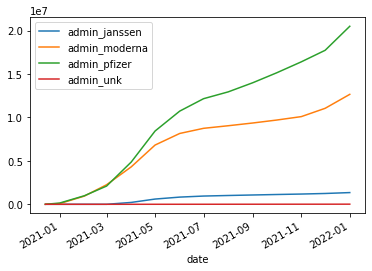

In [17]:
# trend in administration of each vax manufacturer 
ny_m_plt = df_ny_m.reset_index()
ny_m_plt.plot(x="date", y=["admin_janssen", "admin_moderna", "admin_pfizer", "admin_unk"], kind="line")

### covid_cases
Covid cases in NY

In [54]:
#read data
# open zipped dataset
with zipfile.ZipFile("data/COVID-19_Case_Surveillance_Public_Use_Data_with_Geography.csv.zip") as z:
   # open the csv file in the dataset
   with z.open("COVID-19_Case_Surveillance_Public_Use_Data_with_Geography.csv") as f:
      # read the dataset
      covid_df = pd.read_csv(f)
      # display dataset
      print(covid_df.head())

  case_month res_state  state_fips_code res_county  county_fips_code  \
0    2021-10        NY               36      ESSEX           36031.0   
1    2021-01        NY               36  JEFFERSON           36045.0   
2    2021-01        NY               36     NASSAU           36059.0   
3    2020-09        NY               36    STEUBEN           36101.0   
4    2021-03        NY               36     ALBANY           36001.0   

        age_group     sex                           race        ethnicity  \
0  18 to 49 years  Female                            NaN              NaN   
1  18 to 49 years    Male                          Black              NaN   
2  18 to 49 years    Male  American Indian/Alaska Native  Hispanic/Latino   
3  18 to 49 years    Male                        Missing              NaN   
4  18 to 49 years  Female                          Black  Hispanic/Latino   

   case_positive_specimen_interval  case_onset_interval  process exposure_yn  \
0                       

In [55]:
covid_df.columns #column names

Index(['case_month', 'res_state', 'state_fips_code', 'res_county',
       'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity',
       'case_positive_specimen_interval', 'case_onset_interval', 'process',
       'exposure_yn', 'current_status', 'symptom_status', 'hosp_yn', 'icu_yn',
       'death_yn', 'underlying_conditions_yn'],
      dtype='object')

In [56]:
covid_df.dtypes

case_month                          object
res_state                           object
state_fips_code                      int64
res_county                          object
county_fips_code                   float64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
process                             object
exposure_yn                         object
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
dtype: object

In [57]:
covid_df.shape

(3068197, 19)

In [58]:
#data cleaning
covid_df['case_month'] = pd.to_datetime(covid_df['case_month']) #convert to date

In [59]:
covid_df.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2021-10-01,NY,36,ESSEX,36031.0,18 to 49 years,Female,NaN,NaN,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
1,2021-01-01,NY,36,JEFFERSON,36045.0,18 to 49 years,Male,Black,NaN,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,No,Missing,NaN,NaN
2,2021-01-01,NY,36,NASSAU,36059.0,18 to 49 years,Male,American Indian/Alaska Native,Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,No,Missing,No,NaN
3,2020-09-01,NY,36,STEUBEN,36101.0,18 to 49 years,Male,Missing,NaN,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
4,2021-03-01,NY,36,ALBANY,36001.0,18 to 49 years,Female,Black,Hispanic/Latino,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN


In [60]:
covid_df.sample(10, random_state = 42)

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
3035816,2021-01-01,NY,36,KINGS,36047.0,50 to 64 years,Female,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Probable Case,Symptomatic,Missing,Missing,Missing,NaN
353013,2021-12-01,NY,36,CHENANGO,36017.0,18 to 49 years,Male,White,Non-Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
2447365,2020-04-01,NY,36,NEW YORK,36061.0,65+ years,Male,White,Unknown,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,Yes,Unknown,Unknown,Yes
1300224,2021-02-01,NY,36,KINGS,36047.0,18 to 49 years,Female,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,NaN
658764,2020-09-01,NY,36,CHAUTAUQUA,36013.0,65+ years,Female,Missing,Unknown,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
2463926,2021-02-01,NY,36,QUEENS,36081.0,18 to 49 years,Male,Unknown,Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,NaN
438541,2021-01-01,NY,36,SCHENECTADY,36093.0,50 to 64 years,Female,White,Unknown,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN
1242710,2021-02-01,NY,36,ERIE,36029.0,18 to 49 years,Female,White,Non-Hispanic/Latino,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN
2580841,2021-01-01,NY,36,QUEENS,36081.0,65+ years,Female,Asian,Non-Hispanic/Latino,0.0,NaN,Missing,Missing,Probable Case,Unknown,Missing,Missing,Missing,Yes
1217306,2021-08-01,NY,36,RICHMOND,36085.0,0 - 17 years,Male,Unknown,Unknown,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,NaN


In [61]:
covid_df.describe(include = 'all',datetime_is_numeric=True) #describe and include string columns

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
count,3068197,3068197,3068197.0,3053408,3.053408e+06,3050343,3031289,2701592,2638995,2.100615e+06,1.053640e+06,3068197,3068197,3068197,3068197,3068197,3068197,3007799,365602
unique,NaN,1,NaN,59,NaN,5,4,8,4,NaN,NaN,9,3,2,4,4,4,4,2
top,NaN,NY,NaN,KINGS,NaN,18 to 49 years,Female,White,Unknown,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,Yes
freq,NaN,3068197,NaN,393598,NaN,1591113,1565104,1042926,1302573,NaN,NaN,3067972,3030449,2711320,1371555,2336171,2782922,1607526,365600
mean,2021-01-26 14:13:51.511957248,NaN,36.0,NaN,3.606323e+04,NaN,NaN,NaN,NaN,4.617895e-01,2.521355e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2020-01-01 00:00:00,NaN,36.0,NaN,3.600100e+04,NaN,NaN,NaN,NaN,-5.500000e+01,-4.600000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2020-10-01 00:00:00,NaN,36.0,NaN,3.604700e+04,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2021-01-01 00:00:00,NaN,36.0,NaN,3.606100e+04,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2021-08-01 00:00:00,NaN,36.0,NaN,3.608500e+04,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2021-12-01 00:00:00,NaN,36.0,NaN,3.612300e+04,NaN,NaN,NaN,NaN,8.100000e+01,8.000000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


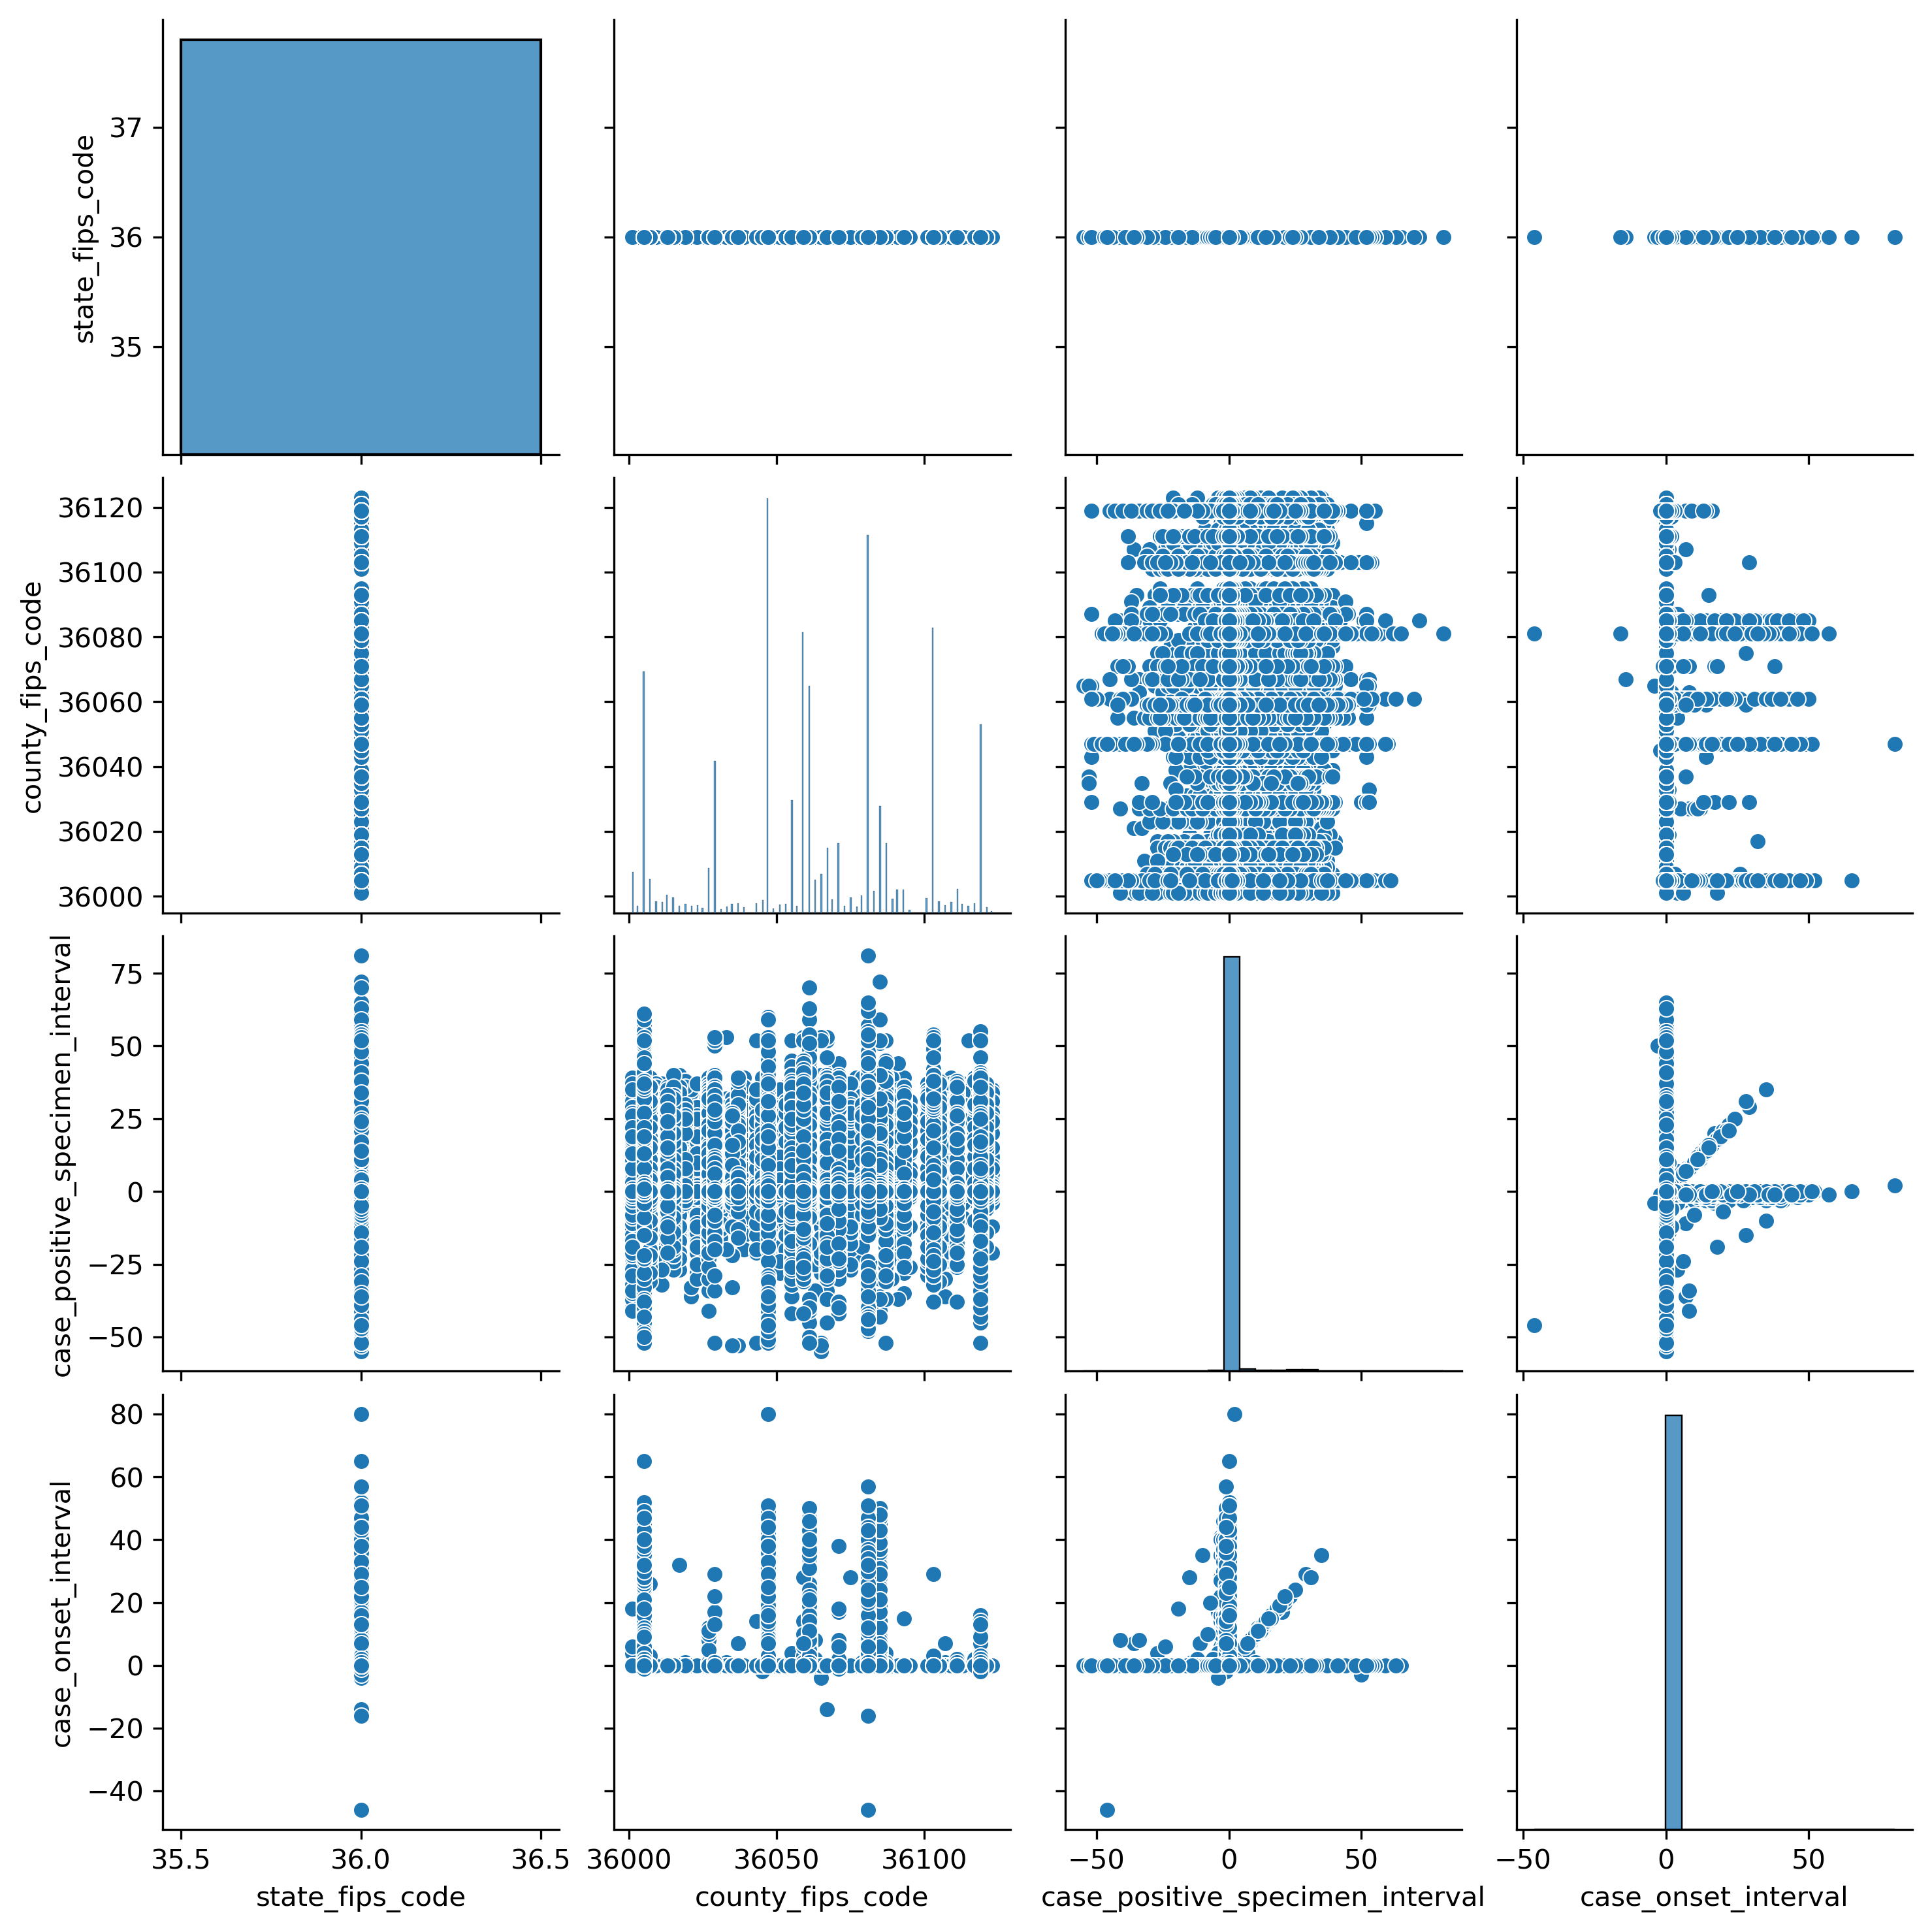

In [62]:
sns.pairplot(covid_df)

<AxesSubplot:>

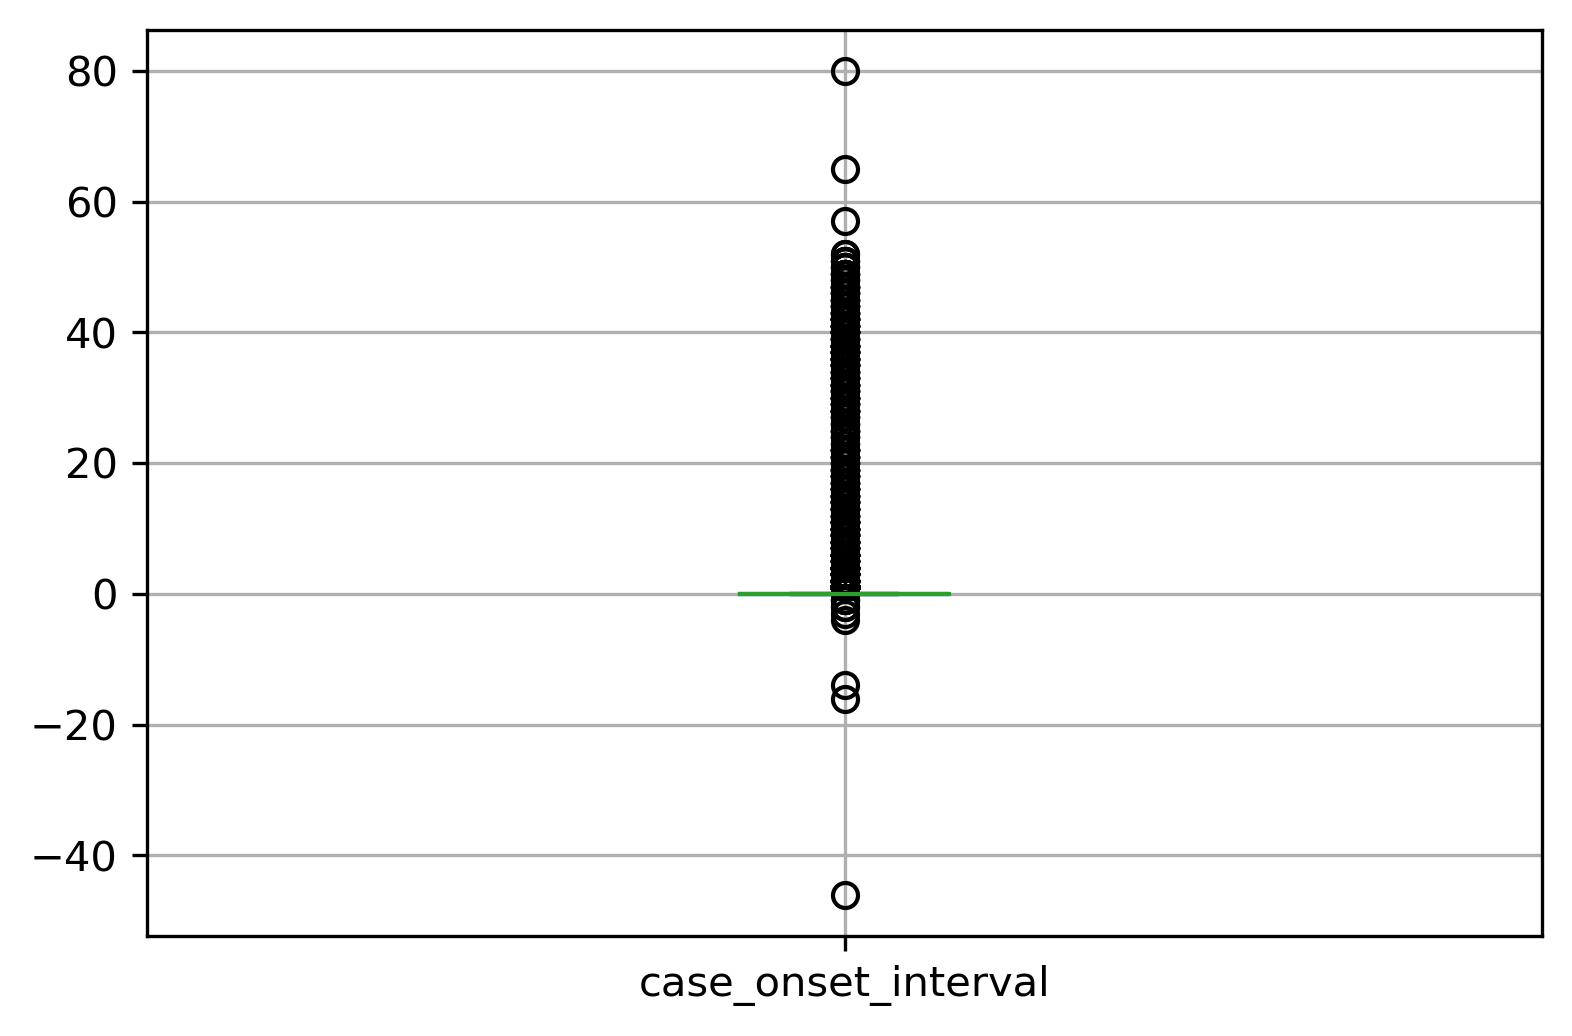

In [63]:
covid_df.boxplot('case_onset_interval')

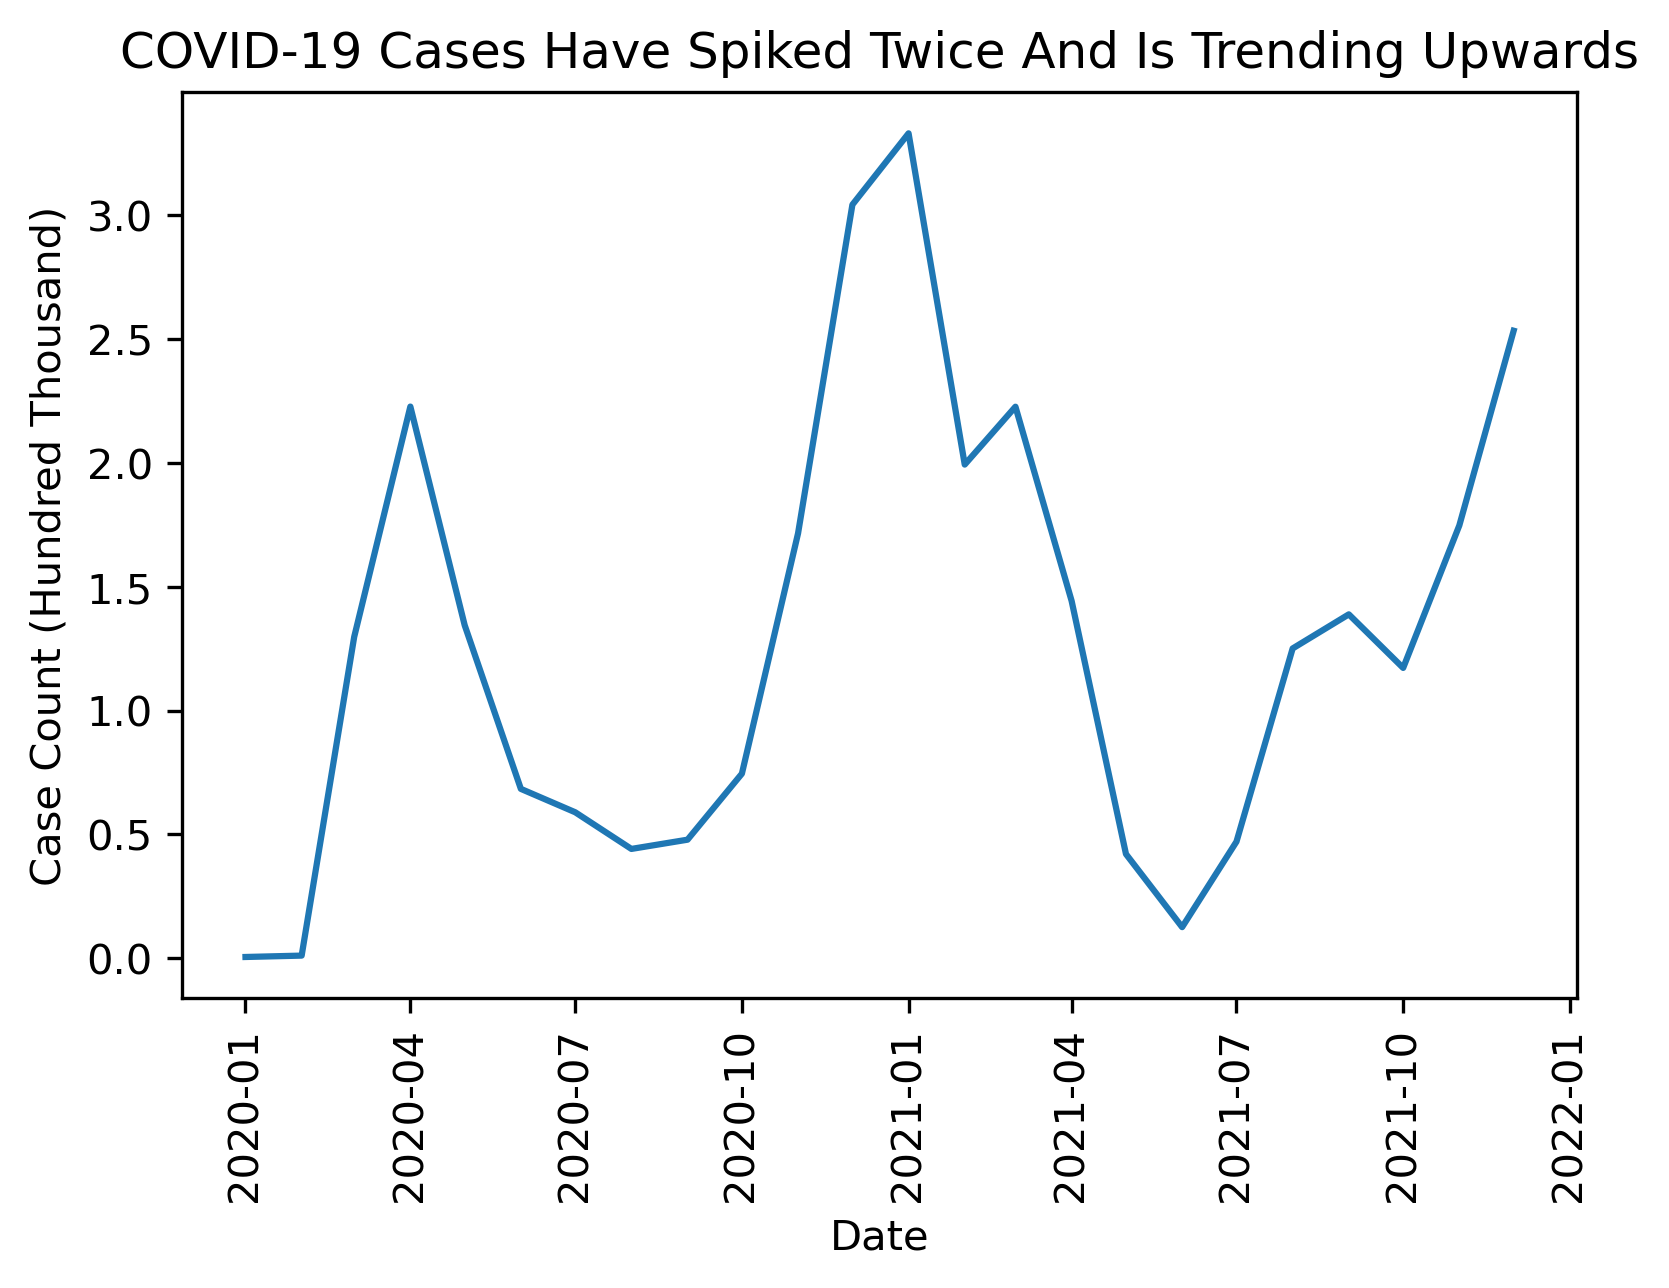

In [64]:
#covid cases trend
trend_df = covid_df.groupby(['case_month']).size().reset_index(name = 'case_count').set_index('case_month')
trend_df['case_count_per_100k'] = trend_df['case_count']/100000
plt.plot(trend_df.index,trend_df['case_count_per_100k'])
plt.title('COVID-19 Cases Have Spiked Twice And Is Trending Upwards')
plt.xlabel('Date')
plt.ylabel('Case Count (Hundred Thousand)')
plt.xticks(rotation=90)
plt.show()

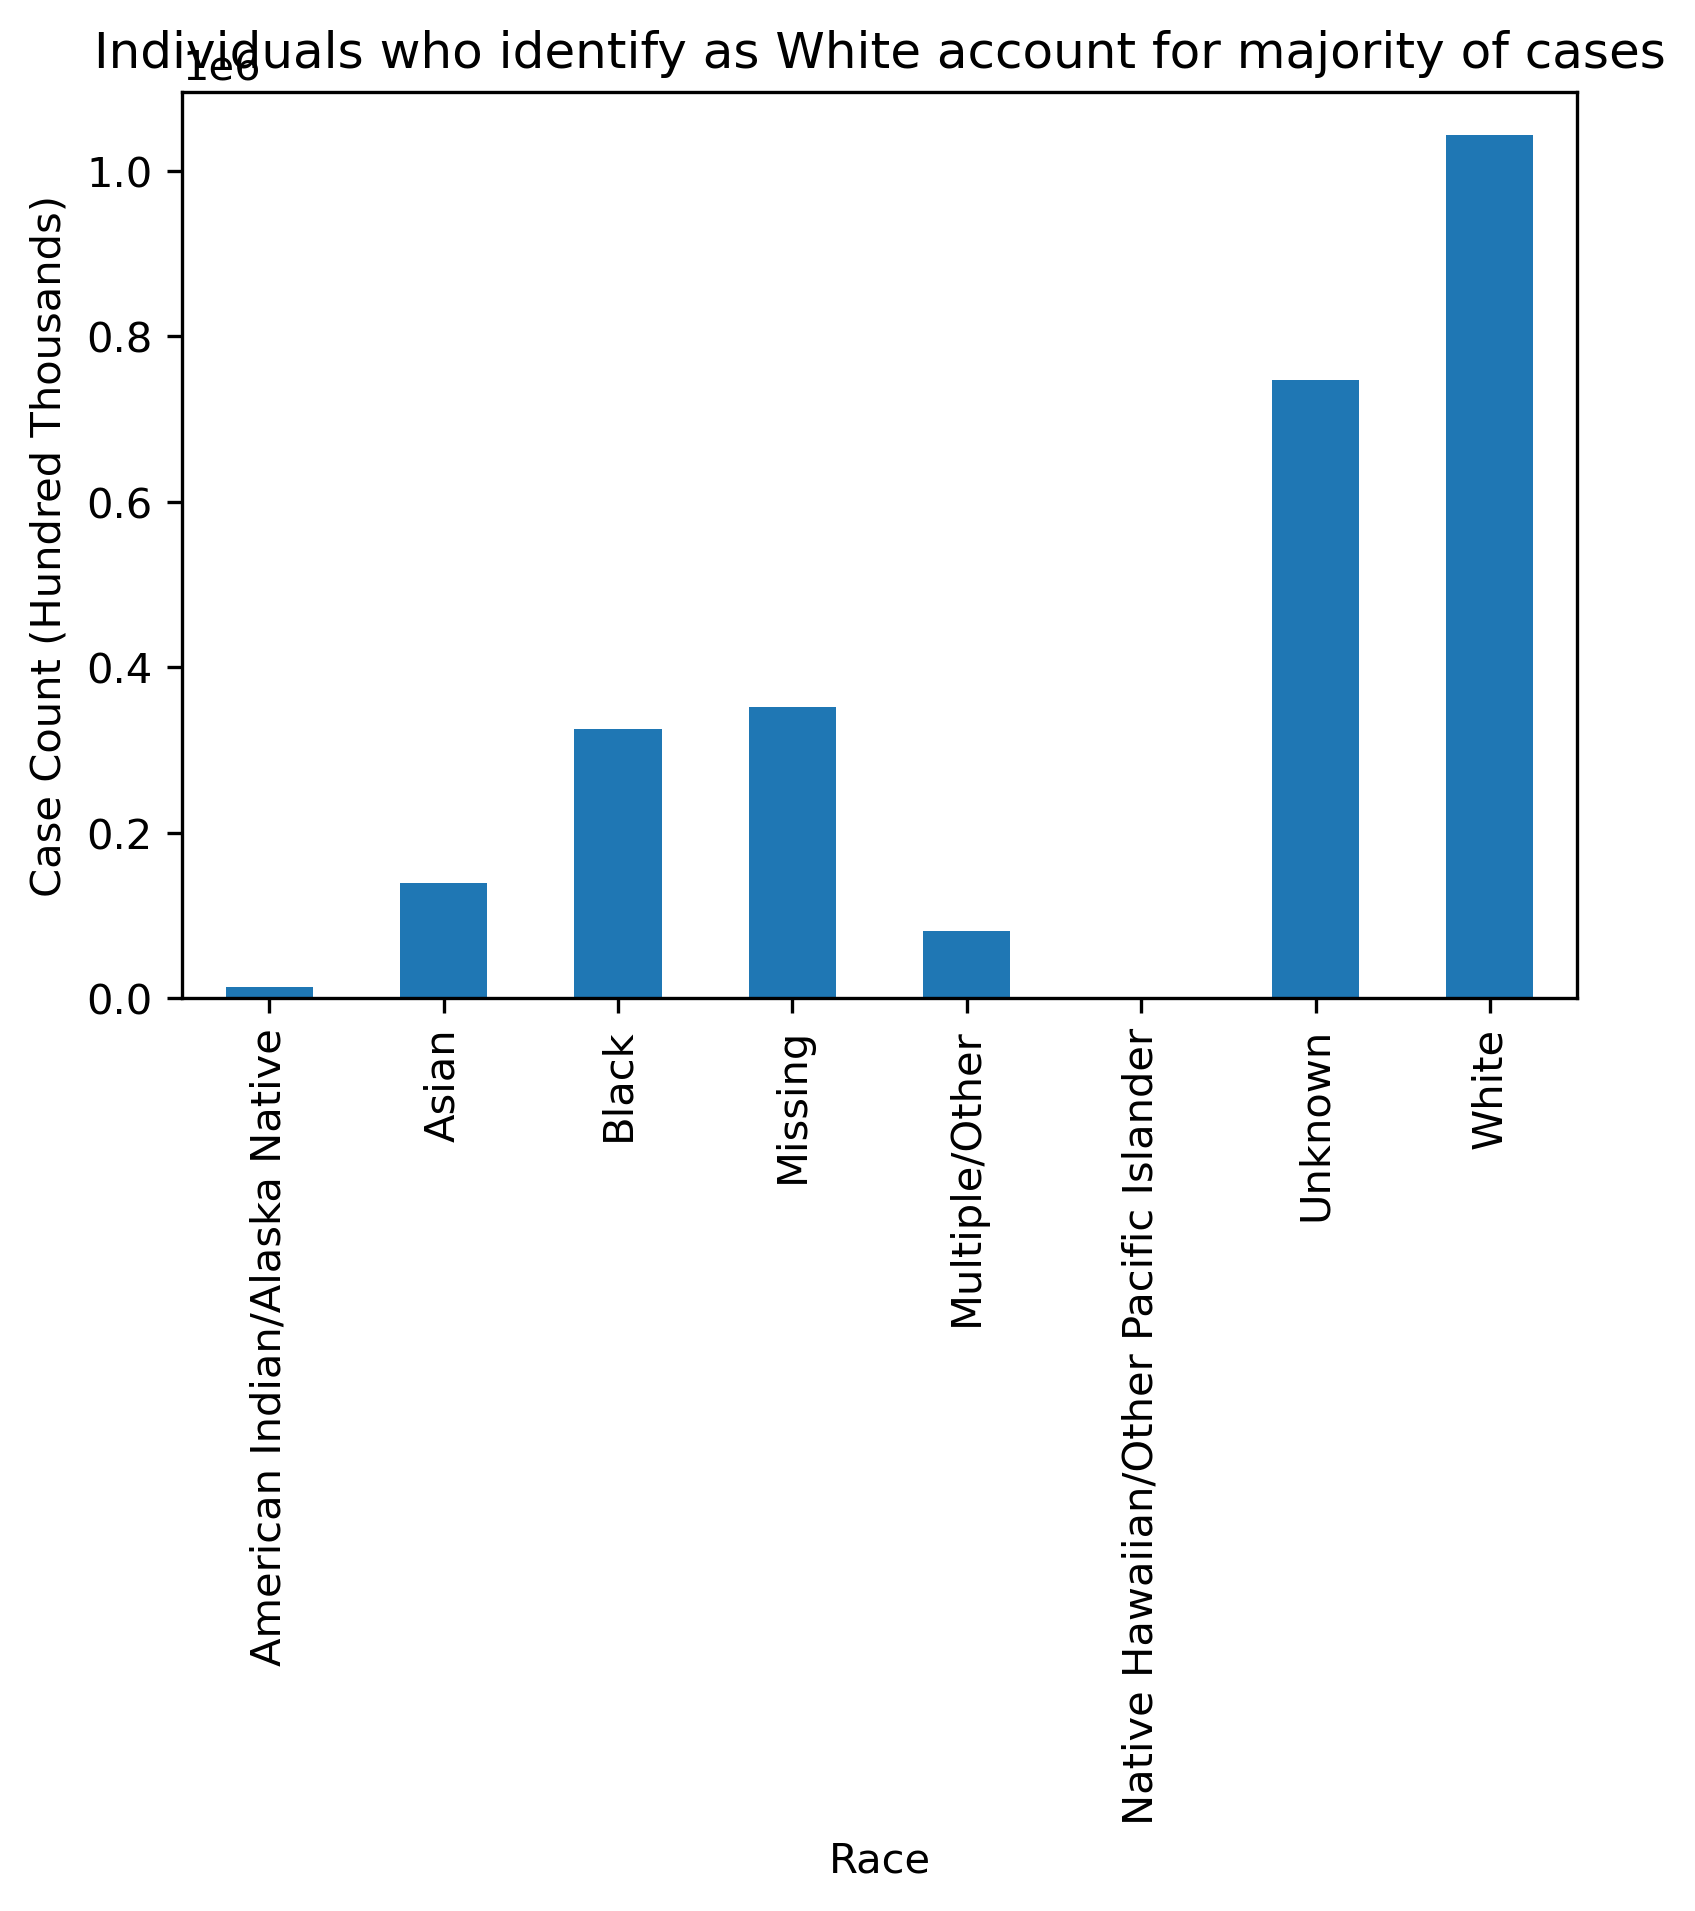

In [69]:
covid_df.groupby(['race']).size().plot.bar()
plt.title('Individuals who identify as White account for majority of cases')
plt.xlabel('Race')
plt.ylabel('Case Count (Hundred Thousands)')
plt.xticks(rotation=90)
plt.show()

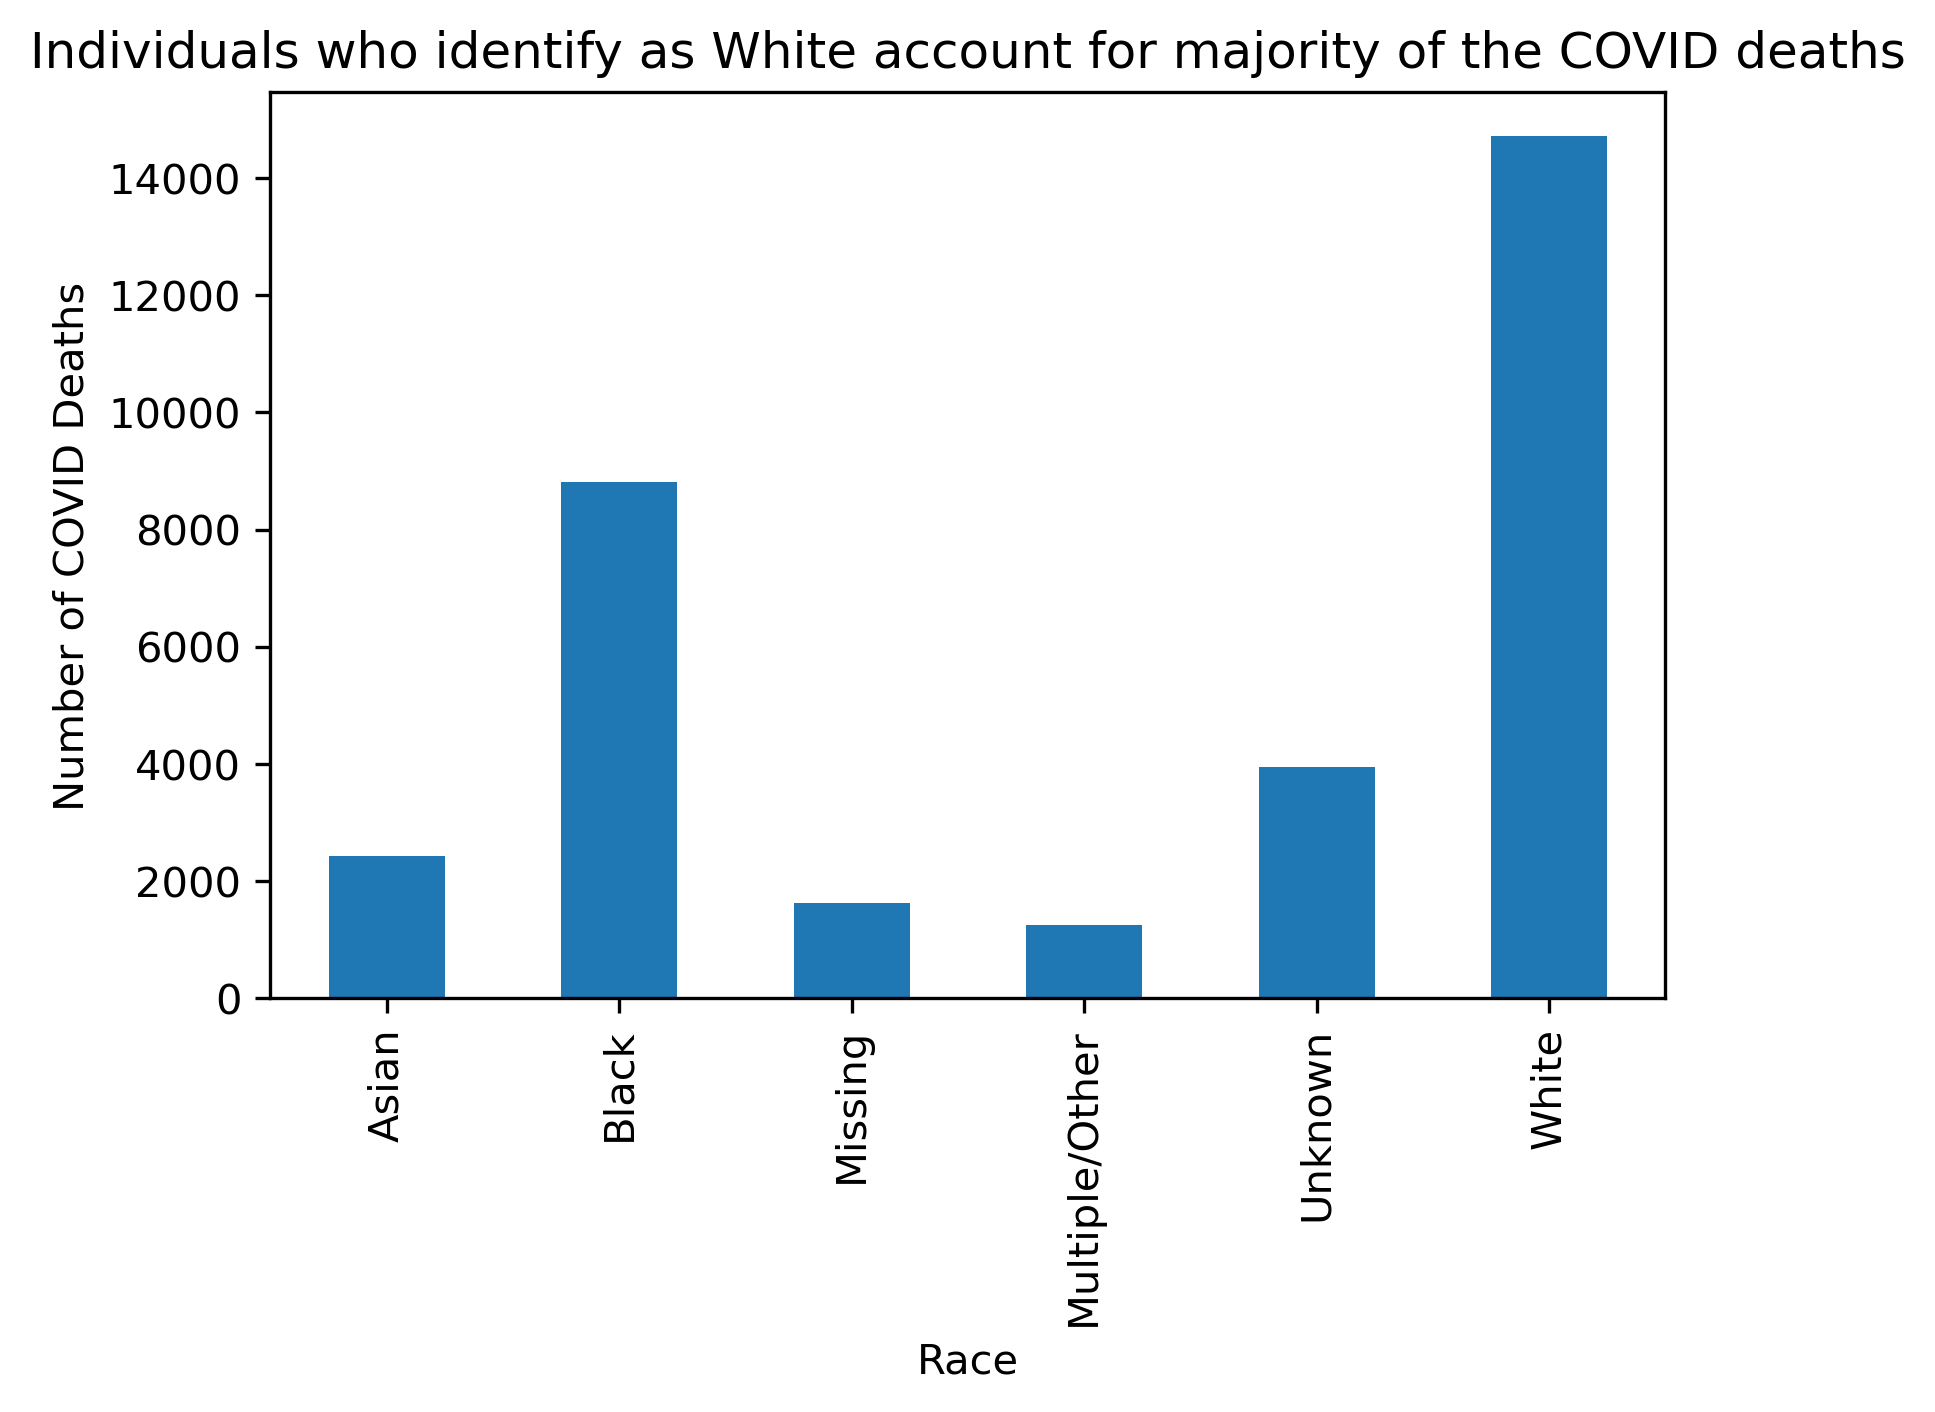

In [70]:
#death status per race
death_df = covid_df[covid_df['death_yn'] == 'Yes'] 
death_df.groupby(['race']).size().plot.bar()
plt.title('Individuals who identify as White account for majority of the COVID deaths')
plt.xlabel('Race')
plt.ylabel('Number of COVID Deaths')
plt.xticks(rotation=90)
plt.show()

In [71]:
#death status per state
death_df.groupby(['res_county']).size().reset_index(name = 'count')

,res_county,count
0,ALBANY,92
1,BRONX,5596
2,BROOME,27
3,DUTCHESS,38
4,ERIE,1975
5,KINGS,9552
6,MONROE,269
7,NASSAU,1749
8,NEW YORK,3465
9,NIAGARA,42


### census_data

### percent_vaccinated_race & percent_cases_race

### vaers